# GEO Behavior Analysis (TD Bank Capstone)

This notebook follows the same structure as `trxNotebook.ipynb` and focuses on
**geo-based behavioral signals** derived from client location activity.

Sections:
1. **Setup** – environment and path configuration (mirrors transaction notebook)
2. **Overview** – temporal and spatial characteristics of geo events
3. **Analysis** – client-level geo engagement and diversity patterns


## 1) Setup

This section mirrors the transaction notebook setup:
- unified `BASE_DIR`
- fold discovery
- shared imports


In [15]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths (match trxNotebook.ipynb)
# -----------------------------
BASE_DIR = Path("data/detail/geo").resolve()

print("BASE_DIR:", BASE_DIR)


BASE_DIR: /Users/xinyanli/Desktop/CapstoneTD/data/detail/geo


In [16]:
# Discover fold directories (same pattern as transaction notebook)
fold_dirs = sorted(
    [p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.startswith("fold=")],
    key=lambda p: p.name
)

print("Found folds:", [d.name for d in fold_dirs])


Found folds: ['fold=0', 'fold=1', 'fold=2', 'fold=3', 'fold=4']


## 2) Overview: Geo Data Characteristics

This section provides a high-level view of geo activity:
- dataset scale across folds
- temporal distribution of geo events
- spatial granularity (geohash_4 / 5 / 6)
- client-level location coverage



=== fold=0 ===
Number of parquet files: 92
Total events: 13814561
Unique clients: 14863

Time range:
2021-12-11 19:43:12.261628 → 2022-12-31 20:59:56.255167

Unique geohash counts:
geohash_4: 11081
geohash_5: 58574
geohash_6: 253538


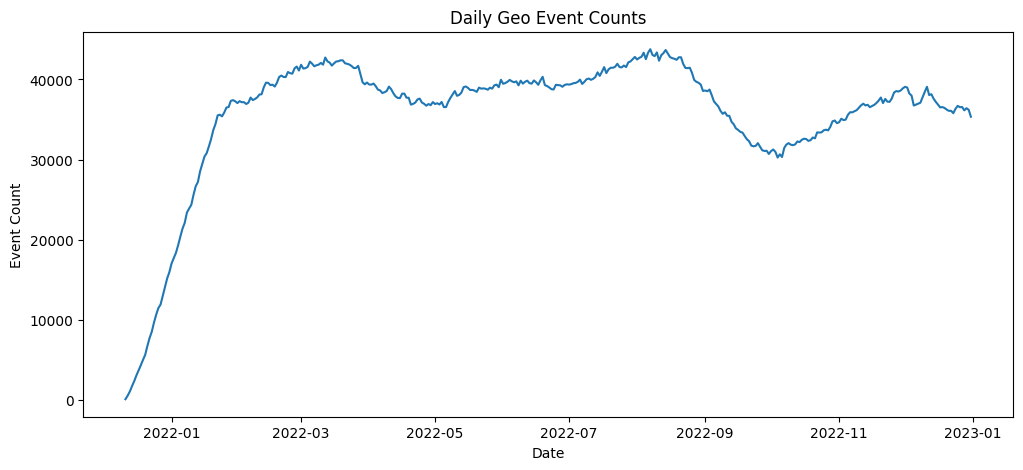

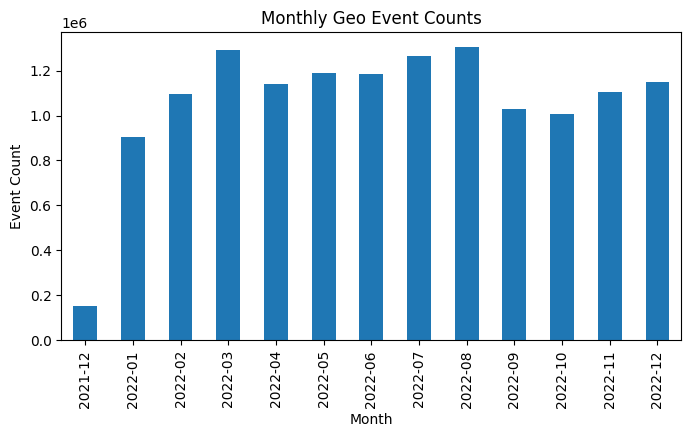

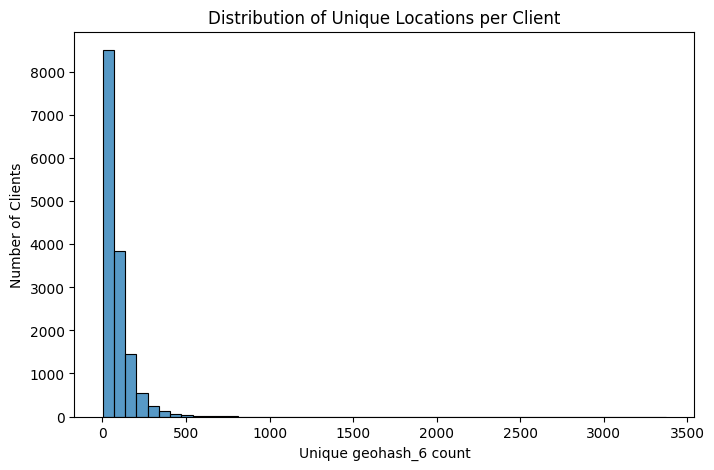

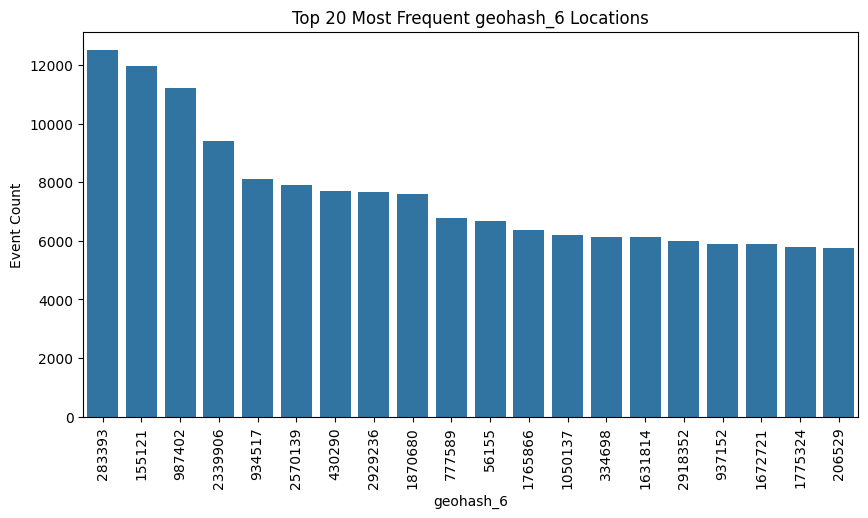


=== fold=1 ===
Number of parquet files: 92
Total events: 12955551
Unique clients: 14409

Time range:
2021-12-11 19:28:09.933994 → 2022-12-31 20:59:58.725788

Unique geohash counts:
geohash_4: 11340
geohash_5: 58737
geohash_6: 250735


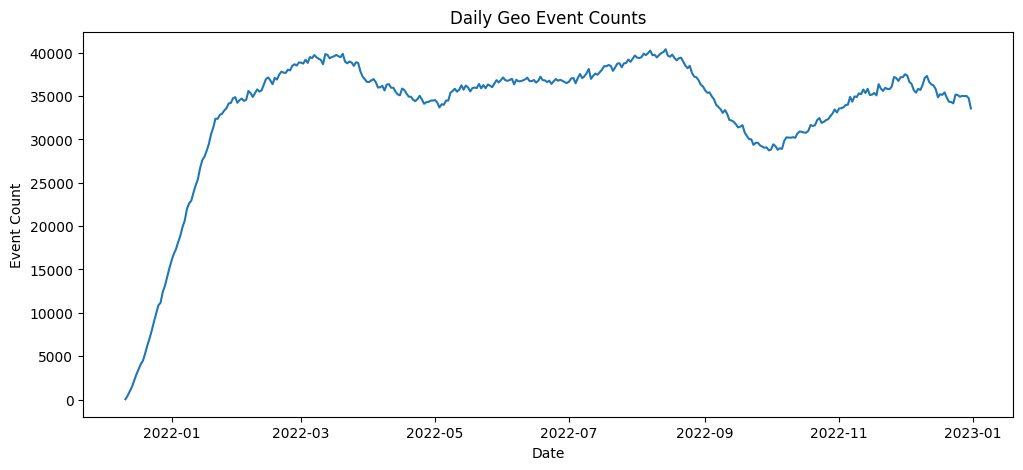

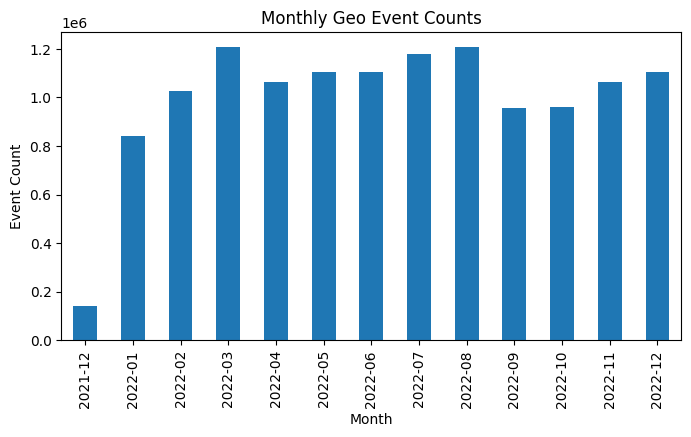

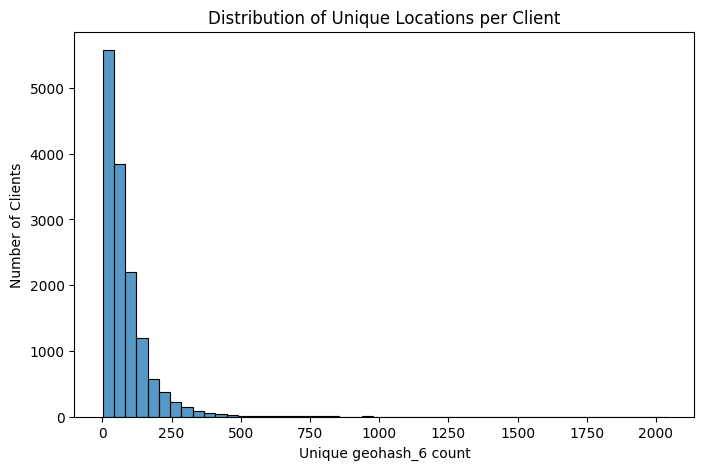

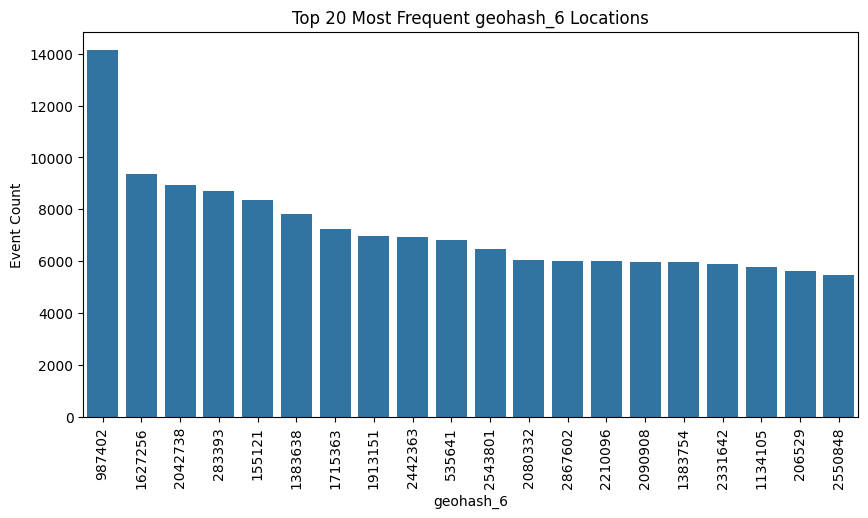


=== fold=2 ===
Number of parquet files: 92
Total events: 13155672
Unique clients: 14396

Time range:
2021-12-11 19:41:45.781566 → 2022-12-31 20:59:58.184193

Unique geohash counts:
geohash_4: 11015
geohash_5: 58669
geohash_6: 252692


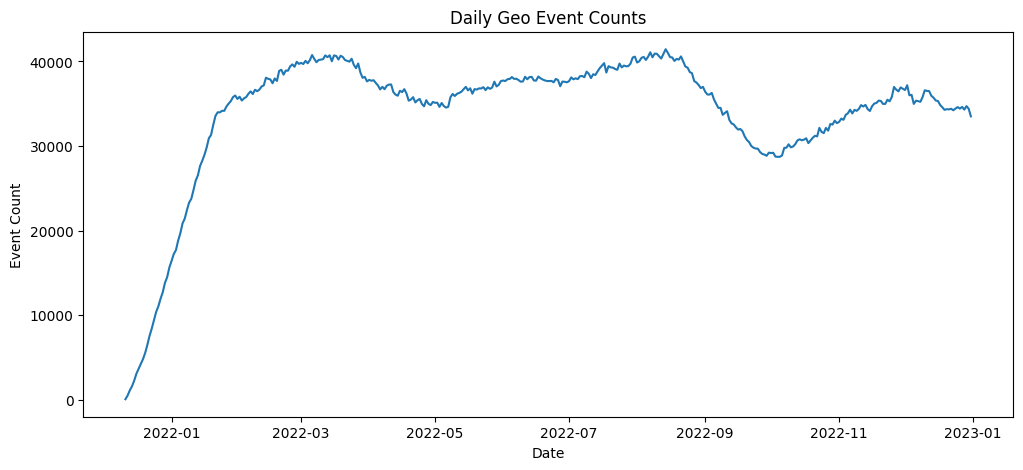

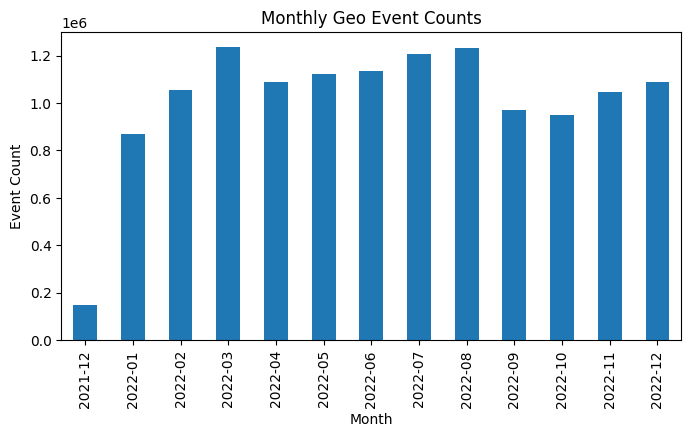

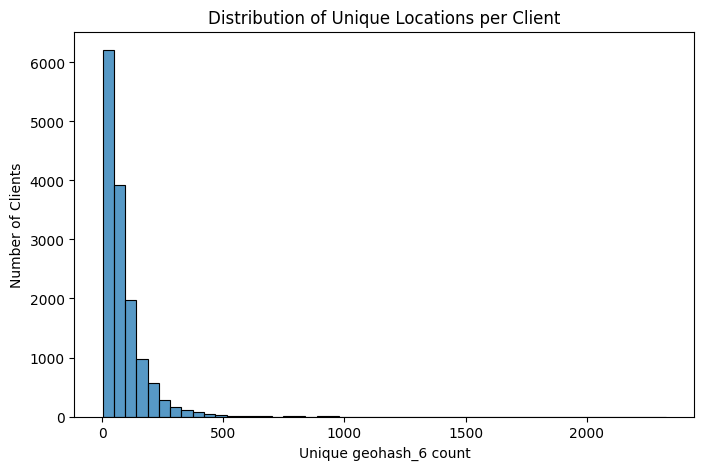

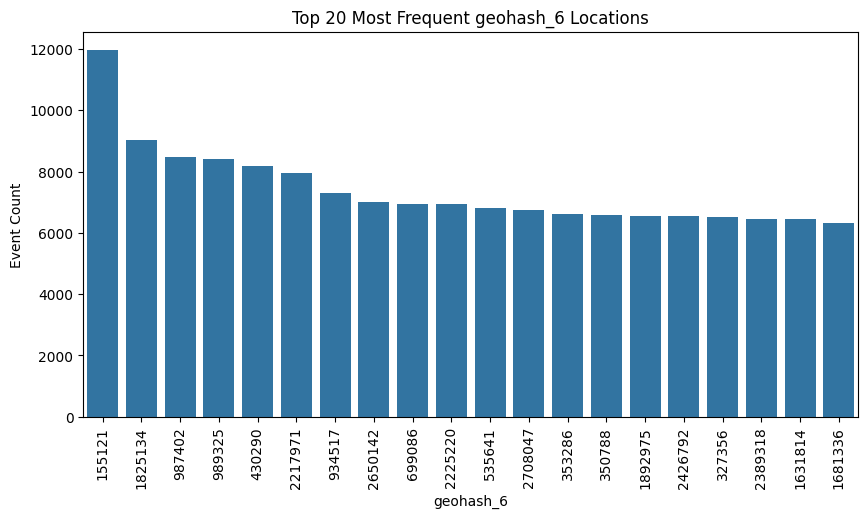


=== fold=3 ===
Number of parquet files: 92
Total events: 13208817
Unique clients: 14380

Time range:
2021-12-11 19:27:07.507106 → 2022-12-31 20:59:58.498137

Unique geohash counts:
geohash_4: 10862
geohash_5: 57640
geohash_6: 247872


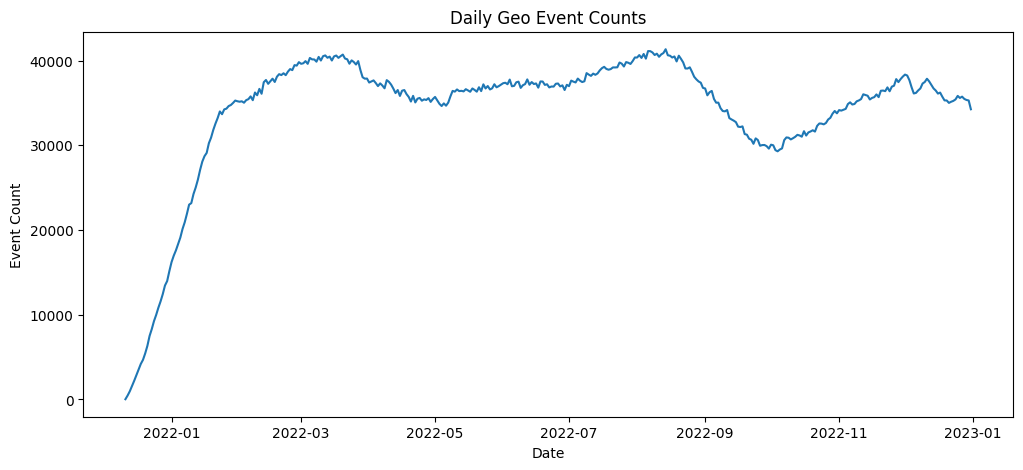

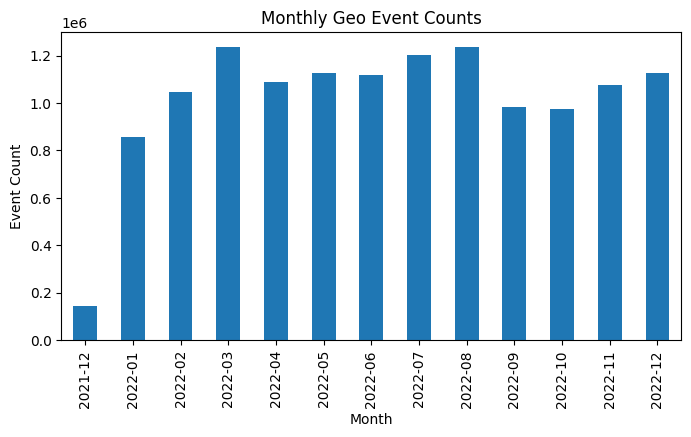

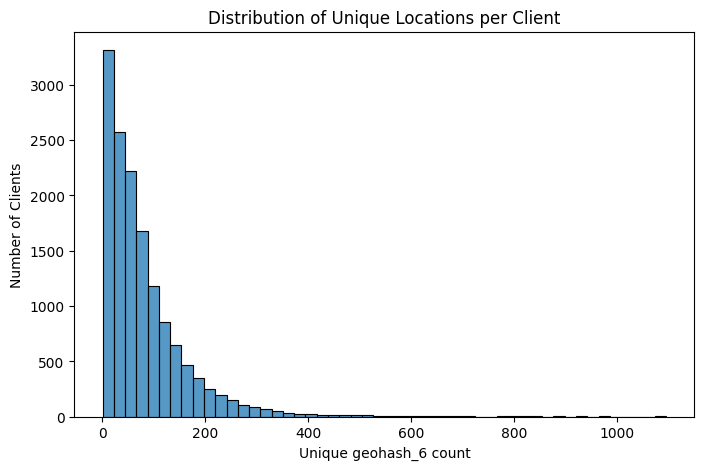

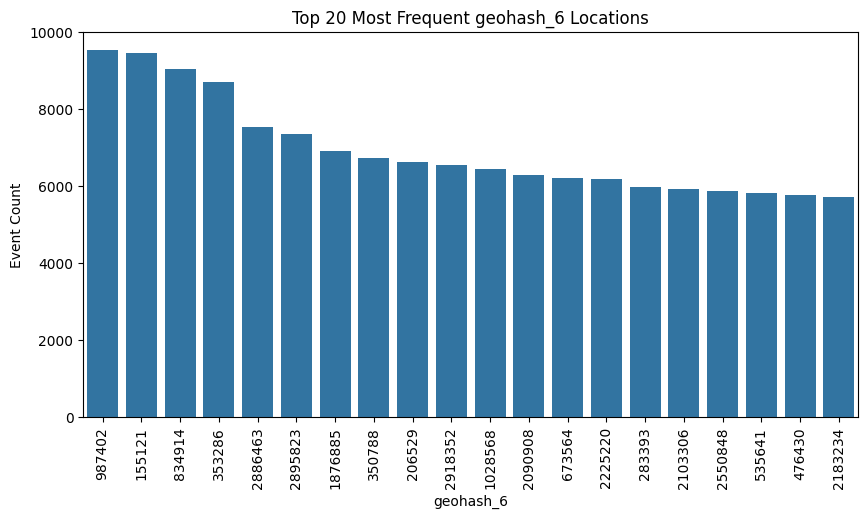


=== fold=4 ===
Number of parquet files: 92
Total events: 13161123
Unique clients: 14525

Time range:
2021-12-11 19:33:48.090861 → 2022-12-31 20:59:58.097984

Unique geohash counts:
geohash_4: 10846
geohash_5: 57953
geohash_6: 248988


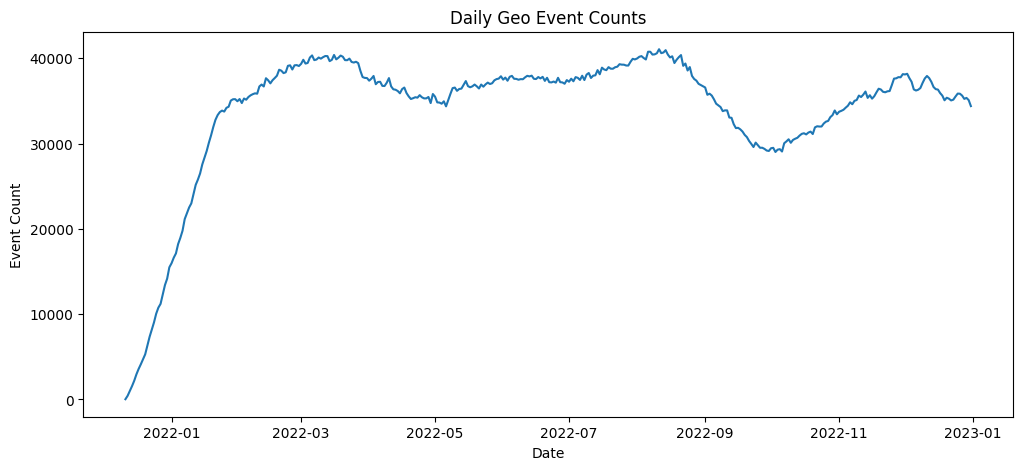

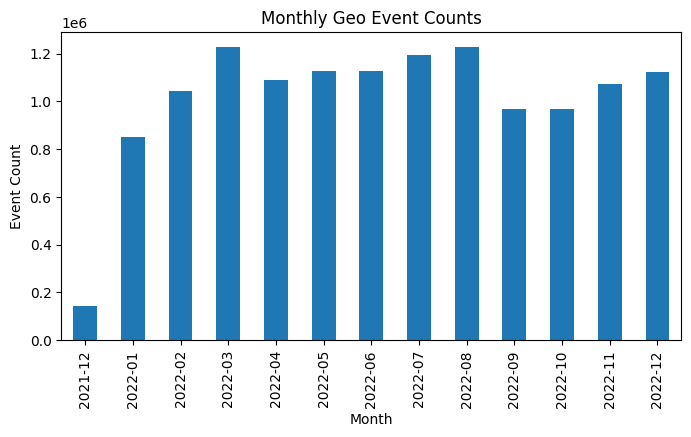

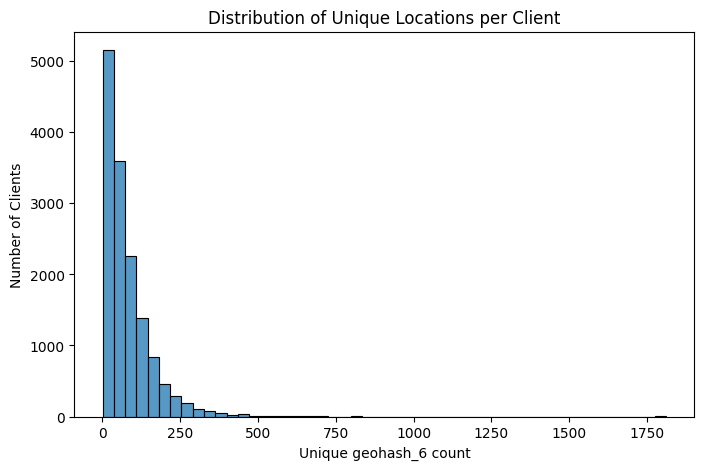

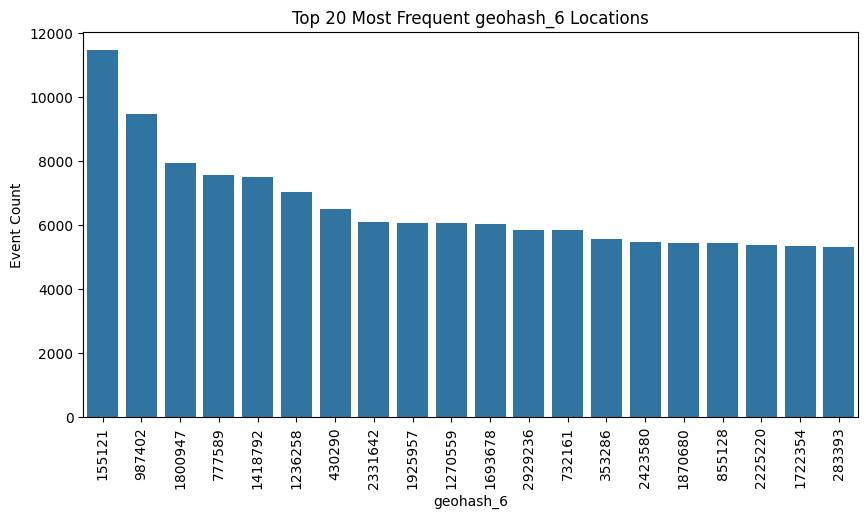

In [26]:
import pyarrow.parquet as pq

for d in fold_dirs:
    print(f"\n=== {d.name} ===")

    # ------------------------------------------------
    # Load parquet files under each fold (trx-style)
    # ------------------------------------------------
    parquet_files = sorted(d.glob("*.parquet"))
    print(f"Number of parquet files: {len(parquet_files)}")

    # 读取并合并（EDA 用，size OK）
    df = pd.concat(
        [pq.read_table(p).to_pandas() for p in parquet_files],
        ignore_index=True
    )

    # time parsing
    df["event_time"] = pd.to_datetime(df["event_time"])

    # ---- basic stats ----
    print("Total events:", len(df))
    print("Unique clients:", df["client_id"].nunique())

    print("\nTime range:")
    print(df["event_time"].min(), "→", df["event_time"].max())

    print("\nUnique geohash counts:")
    print("geohash_4:", df["geohash_4"].nunique())
    print("geohash_5:", df["geohash_5"].nunique())
    print("geohash_6:", df["geohash_6"].nunique())

    # daily time series
    df["date"] = df["event_time"].dt.date
    daily_counts = df.groupby("date").size()

    plt.figure(figsize=(12, 5))
    daily_counts.plot()
    plt.title("Daily Geo Event Counts")
    plt.xlabel("Date")
    plt.ylabel("Event Count")
    plt.show()

    # monthly bar
    df["month"] = df["event_time"].dt.to_period("M")
    monthly_counts = df.groupby("month").size()

    plt.figure(figsize=(8, 4))
    monthly_counts.plot(kind="bar")
    plt.title("Monthly Geo Event Counts")
    plt.xlabel("Month")
    plt.ylabel("Event Count")
    plt.show()

    # unique locations per client
    client_geo_counts = df.groupby("client_id")["geohash_6"].nunique()

    plt.figure(figsize=(8, 5))
    sns.histplot(client_geo_counts, bins=50)
    plt.title("Distribution of Unique Locations per Client")
    plt.xlabel("Unique geohash_6 count")
    plt.ylabel("Number of Clients")
    plt.show()

    # Top 20 geohash
    top_geo6 = df["geohash_6"].value_counts().head(20)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_geo6.index.astype(str), y=top_geo6.values)
    plt.xticks(rotation=90)
    plt.title("Top 20 Most Frequent geohash_6 Locations")
    plt.ylabel("Event Count")
    plt.show()


## 3) Analysis: Client-Level Geo Engagement Patterns

Building on the overview, we aggregate geo events at the client level to examine:

- **engagement**: total geo activity volume
- **diversity**: number of distinct locations visited

This helps identify different behavioral segments using geo signals alone.


In [28]:
import pyarrow.dataset as ds

geo_cols = ["client_id", "event_time", "geohash_4", "geohash_5", "geohash_6"]

geo_ds = ds.dataset(str(BASE_DIR), format="parquet")

geo = geo_ds.to_table(columns=geo_cols).to_pandas()
geo["event_time"] = pd.to_datetime(geo["event_time"], errors="coerce")

print("Raw geo shape:", geo.shape)
geo.head()


Raw geo shape: (66295724, 5)


,client_id,event_time,geohash_4,geohash_5,geohash_6
0,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-03-25 13:39:51.569288,41342,406579,1018528
1,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-06-11 07:21:32.505485,41342,406579,1018528
2,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-08-08 21:25:07.461323,41342,406579,1018528
3,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-07-23 11:32:03.433401,41342,406579,1018528
4,397d52b11ce72699a5482e5397f63a03af1636c85e9e61...,2022-05-28 08:18:19.843885,41342,406579,1018528


In [29]:
obs_start = "2021-12-11"
obs_end   = "2022-12-31"

mask = (geo["event_time"] >= obs_start) & (geo["event_time"] <= obs_end)
geo = geo.loc[mask].copy()

print("After time filtering:", geo.shape)


After time filtering: (66124646, 5)


In [30]:
geo_client = (
    geo.groupby("client_id")
       .agg(
           n_geo_events=("geohash_6", "size"),
           n_geo4_unique=("geohash_4", "nunique"),
           n_geo5_unique=("geohash_5", "nunique"),
           n_geo6_unique=("geohash_6", "nunique"),
       )
       .reset_index()
)

geo_client["geo6_unique_ratio"] = (
    geo_client["n_geo6_unique"] / geo_client["n_geo_events"]
)

geo_client.describe(percentiles=[0.5, 0.9, 0.99])


,n_geo_events,n_geo4_unique,n_geo5_unique,n_geo6_unique,geo6_unique_ratio
count,72552.000000,72552.000000,72552.000000,72552.000000,72552.000000
mean,911.410382,12.543017,31.297442,79.675474,0.177755
std,1193.976509,12.855319,32.206477,84.400998,0.181530
min,1.000000,1.000000,1.000000,1.000000,0.001623
50%,505.000000,9.000000,23.000000,57.000000,0.118019
90%,2288.000000,27.000000,67.000000,175.000000,0.365840
99%,5572.980000,59.000000,146.000000,391.490000,1.000000
max,39487.000000,648.000000,1654.000000,3371.000000,1.000000


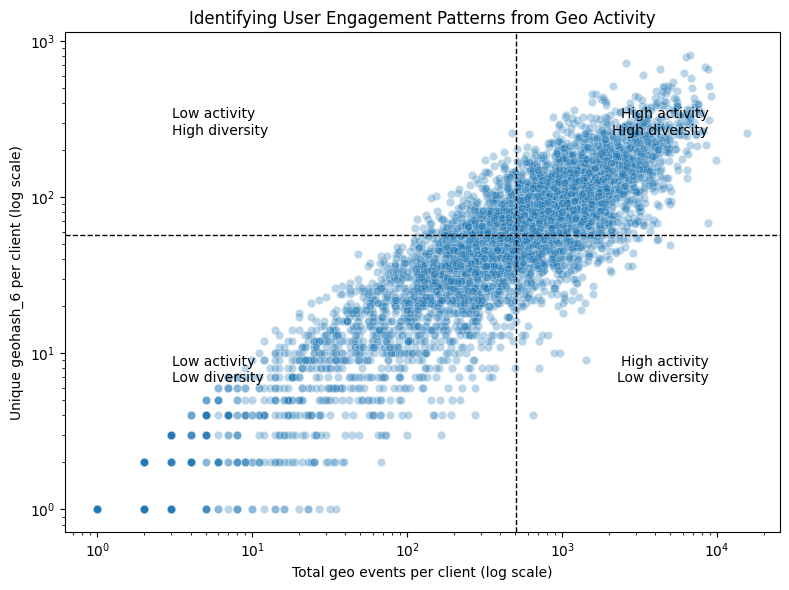

In [31]:
x_thr = geo_client["n_geo_events"].median()
y_thr = geo_client["n_geo6_unique"].median()

plt.figure(figsize=(8, 6))

sampled = geo_client.sample(min(5000, len(geo_client)), random_state=42)

sns.scatterplot(
    data=sampled,
    x="n_geo_events",
    y="n_geo6_unique",
    alpha=0.3
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total geo events per client (log scale)")
plt.ylabel("Unique geohash_6 per client (log scale)")
plt.title("Identifying User Engagement Patterns from Geo Activity")

ax = plt.gca()
ax.axvline(x=x_thr, linestyle="--", color="black", linewidth=1)
ax.axhline(y=y_thr, linestyle="--", color="black", linewidth=1)

ax.text(0.15, 0.3, "Low activity\nLow diversity", transform=ax.transAxes)
ax.text(0.9, 0.3, "High activity\nLow diversity", transform=ax.transAxes, ha="right")
ax.text(0.15, 0.85, "Low activity\nHigh diversity", transform=ax.transAxes, va="top")
ax.text(0.9, 0.85, "High activity\nHigh diversity", transform=ax.transAxes, ha="right", va="top")

plt.tight_layout()
plt.show()


## Summary: Insights from Geo-Based EDA

The geo-event data exhibit a clear and stable behavioral structure across time, space, and clients.

From the temporal analysis, geo activity is consistently distributed over the observation window, with no abrupt discontinuities in daily or monthly event counts. This suggests that geo signals capture regular client behavior rather than short-lived anomalies.

From the spatial perspective, the hierarchical geohash representation (levels 4, 5, and 6) provides increasing granularity of location information. While a small number of geohash_6 locations account for a large share of total events, most clients interact with a limited and stable set of locations, as reflected in the skewed distribution of unique locations per client.

At the client level, aggregating geo events reveals a meaningful relationship between engagement (total geo events) and spatial diversity (unique geohash_6). The log–log scatter highlights distinct behavioral regimes, ranging from low-activity, low-diversity clients to highly active and spatially diverse clients. These patterns suggest that geo-based features can effectively capture differences in client mobility and routine consistency.

Overall, this exploratory analysis indicates that geo features encode interpretable and behaviorally relevant signals, making them strong candidates for downstream modeling tasks such as client adoption or churn prediction.
